In [1]:
%matplotlib inline
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import torchvision
from tqdm import tqdm
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

In [2]:
train_metadata = torchvision.datasets.MNIST(root='./data', train=True, download=True)
test_metadata = torchvision.datasets.MNIST(root='./data', train=False, download=True)

train_x = train_metadata.data[:50000].unsqueeze(1) / 255
val_x = train_metadata.data[-10000:].unsqueeze(1) / 255
test_x = test_metadata.data.unsqueeze(1) / 255
train_y = train_metadata.targets[:50000]
val_y = train_metadata.targets[-10000:]
test_y = test_metadata.targets

In [3]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
BATCH_SIZE = 256
NUM_TRAIN = 50000
NUM_VAL = 10000
IMG_C = train_x.shape[-3]
IMG_H = train_x.shape[-2]
IMG_W = train_x.shape[-1]

train_data = TensorDataset(train_x, train_y)
val_data = TensorDataset(val_x, val_y)
test_data = TensorDataset(test_x, test_y)

train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE)

In [4]:
class Encoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(Encoder, self).__init__()
        self.encode = nn.Sequential(
          nn.Conv2d(input_dim, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2)),
          nn.ReLU(inplace=True),
          nn.MaxPool2d(kernel_size=2, stride=2),

          nn.Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2)),
          nn.ReLU(inplace=True),
          nn.MaxPool2d(kernel_size=2, stride=2),

          nn.Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
          nn.ReLU(inplace=True),
          nn.MaxPool2d(kernel_size=2, stride=2),

          nn.Flatten()
        )
        self.fc_mu = nn.Linear(128 * 3 * 3, latent_dim)
        self.fc_var = nn.Linear(128 * 3 * 3, latent_dim)

    def forward(self, x):
        encoded = self.encode(x)
        mu = self.fc_mu(encoded)
        log_var = self.fc_var(encoded)
        z = self.reparameterization(mu, log_var)
        return z, mu, log_var

    def reparameterization(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        epsilon = torch.randn_like(std).to(DEVICE)
        z = mu + std * epsilon
        return z

class Decoder(nn.Module):
    def __init__(self, latent_dim, output_dim):
        super(Decoder, self).__init__()
        self.decode = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, 128, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1)),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(128, 64, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1)),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(64, 32, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1)),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(32, output_dim, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1)),
            nn.Flatten()
        )
        self.fc_mu = nn.Linear(31 * 31, IMG_H * IMG_W)
        self.fc_var = nn.Linear(31 * 31, IMG_H * IMG_W)

    def forward(self, x):
        x = x.unsqueeze(-1).unsqueeze(-1)
        x = self.decode(x)
        mu = self.fc_mu(x)
        log_var = self.fc_var(x)
        return mu, log_var

class VAE(nn.Module):
    def __init__(self, encoder, decoder, var=0.5):
        super(VAE, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.var = var

    def forward(self, x):
        z, mu_z, log_var_z = self.encoder(x)
        mu_x, log_var_x = self.decoder(z)
        return mu_z, log_var_z, mu_x, log_var_x

    def reconstruct(self, mu_x, log_var_x):
        std = torch.exp(0.5 * log_var_x)
        epsilon = torch.randn_like(std).to(DEVICE)
        x_recon = torch.sigmoid(mu_x + std * epsilon)
        return x_recon.view(x_recon.shape[0], IMG_C, IMG_H, IMG_W)

In [11]:
LATENT_DIM = 2

encoder = Encoder(input_dim=IMG_C, latent_dim=LATENT_DIM)
decoder = Decoder(latent_dim=LATENT_DIM, output_dim=IMG_C)
vae = VAE(encoder, decoder).to(DEVICE)
print(vae)

VAE(
  (encoder): Encoder(
    (encode): Sequential(
      (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (1): ReLU(inplace=True)
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (4): ReLU(inplace=True)
      (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): ReLU(inplace=True)
      (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (9): Flatten(start_dim=1, end_dim=-1)
    )
    (fc_mu): Linear(in_features=1152, out_features=2, bias=True)
    (fc_var): Linear(in_features=1152, out_features=2, bias=True)
  )
  (decoder): Decoder(
    (decode): Sequential(
      (0): ConvTranspose2d(2, 128, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0

  5%|▌         | 1/20 [00:05<01:52,  5.91s/it]

Epoch 1, Mean Training ELBO -120.4022849987793, Mean Validation ELBO -104.78532755126953


 10%|█         | 2/20 [00:11<01:45,  5.88s/it]

Epoch 2, Mean Training ELBO -273.7064499291992, Mean Validation ELBO -108.5580599609375


 15%|█▌        | 3/20 [00:17<01:40,  5.93s/it]

Epoch 3, Mean Training ELBO -580.7539814453125, Mean Validation ELBO -264.4563013916016


 20%|██        | 4/20 [00:23<01:34,  5.91s/it]

Epoch 4, Mean Training ELBO -658.614401171875, Mean Validation ELBO -933.96105859375


 25%|██▌       | 5/20 [00:29<01:28,  5.90s/it]

Epoch 5, Mean Training ELBO -540.6001452587891, Mean Validation ELBO -308.46002177734374


 30%|███       | 6/20 [00:35<01:22,  5.90s/it]

Epoch 6, Mean Training ELBO -534.9876423681641, Mean Validation ELBO -776.6354908203125


 35%|███▌      | 7/20 [00:41<01:17,  5.94s/it]

Epoch 7, Mean Training ELBO -292.2959416503906, Mean Validation ELBO -323.4186981445313


 40%|████      | 8/20 [00:47<01:11,  5.93s/it]

Epoch 8, Mean Training ELBO -648.6864444140625, Mean Validation ELBO -947.5601672851562


 45%|████▌     | 9/20 [00:53<01:05,  5.93s/it]

Epoch 9, Mean Training ELBO -706.492549921875, Mean Validation ELBO -903.242036328125


 50%|█████     | 10/20 [00:59<00:59,  5.93s/it]

Epoch 10, Mean Training ELBO -783.6405021484375, Mean Validation ELBO -87.06174415283203


 55%|█████▌    | 11/20 [01:05<00:53,  5.96s/it]

Epoch 11, Mean Training ELBO -586.3003892016602, Mean Validation ELBO -1137.00698984375


 60%|██████    | 12/20 [01:11<00:47,  5.97s/it]

Epoch 12, Mean Training ELBO -939.9751490625, Mean Validation ELBO -1161.9567419921875


 65%|██████▌   | 13/20 [01:17<00:41,  5.97s/it]

Epoch 13, Mean Training ELBO -782.2912882373047, Mean Validation ELBO -988.18916875


 70%|███████   | 14/20 [01:23<00:35,  5.96s/it]

Epoch 14, Mean Training ELBO -838.2362281152343, Mean Validation ELBO -428.59710698242185


 75%|███████▌  | 15/20 [01:29<00:29,  6.00s/it]

Epoch 15, Mean Training ELBO -886.8849754882813, Mean Validation ELBO -1168.8102068359376


 80%|████████  | 16/20 [01:35<00:23,  5.99s/it]

Epoch 16, Mean Training ELBO -930.9481687695312, Mean Validation ELBO -1215.50942421875


 85%|████████▌ | 17/20 [01:41<00:17,  5.98s/it]

Epoch 17, Mean Training ELBO -813.0607027929688, Mean Validation ELBO -1254.2707201171875


 90%|█████████ | 18/20 [01:47<00:11,  5.98s/it]

Epoch 18, Mean Training ELBO -847.95855765625, Mean Validation ELBO -1225.0904849609376


 95%|█████████▌| 19/20 [01:53<00:06,  6.01s/it]

Epoch 19, Mean Training ELBO -664.5272981445313, Mean Validation ELBO -1087.410612158203


100%|██████████| 20/20 [01:59<00:00,  5.96s/it]

Epoch 20, Mean Training ELBO -995.1897867089843, Mean Validation ELBO -811.4836971679688


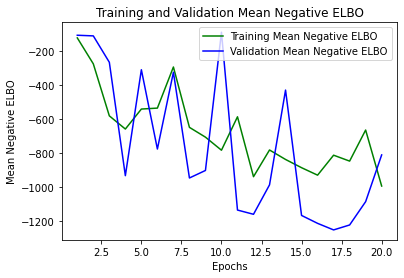

In [12]:
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)

def train_vae(num_epochs, patience=5):
    train_elbos = []
    val_elbos = []
    best_val_elbo = np.inf
    tolerance = 0
    epochs = num_epochs
    for epoch in tqdm(range(num_epochs)):
        overall_train_elbo = 0.0
        overall_val_elbo = 0.0
        for batch in train_dataloader:
            optimizer.zero_grad()
            x, _ = batch
            x = x.to(DEVICE)
            mu_z, log_var_z, mu_x, log_var_x = vae(x)
            x = torch.flatten(x, start_dim=1)
            distances = (x - mu_x) ** 2
            log_p = -0.5 * torch.sum(np.log(2 * np.pi) + log_var_x + distances / log_var_x.exp())
            kl = -0.5 * torch.sum(1 + log_var_z - mu_z.pow(2) - log_var_z.exp())
            negative_elbo = -log_p + kl
            negative_elbo.backward()
            optimizer.step()
            overall_train_elbo += negative_elbo.item()

        for batch in val_dataloader:
            x, _ = batch
            x = x.to(DEVICE)
            with torch.no_grad():
                mu_z, log_var_z, mu_x, log_var_x = vae(x)
                x = torch.flatten(x, start_dim=1)
                distances = (x - mu_x) ** 2
                log_p = -0.5 * torch.sum(np.log(2 * np.pi) + log_var_x + distances / log_var_x.exp())
                kl = -0.5 * torch.sum(1 + log_var_z - mu_z.pow(2) - log_var_z.exp())
                negative_elbo = -log_p + kl
                overall_val_elbo += negative_elbo.item()

        mean_train_elbo = overall_train_elbo / NUM_TRAIN
        mean_val_elbo = overall_val_elbo / NUM_VAL
        print('Epoch {}, Mean Training ELBO {}, Mean Validation ELBO {}'.format(epoch + 1, mean_train_elbo, mean_val_elbo))
        train_elbos.append(mean_train_elbo)
        val_elbos.append(mean_val_elbo)
        if mean_val_elbo < best_val_elbo:
            best_val_elbo = mean_val_elbo
            tolerance = 0
        else:
            tolerance += 1
            if tolerance == patience:
                print('Early Stopped!')
                epochs = epoch + 1
                break
    plt.plot(range(1, epochs + 1), train_elbos, 'g', label='Training Mean Negative ELBO')
    plt.plot(range(1, epochs + 1), val_elbos, 'b', label='Validation Mean Negative ELBO')
    plt.title('Training and Validation Mean Negative ELBO')
    plt.xlabel('Epochs')
    plt.ylabel('Mean Negative ELBO')
    plt.legend()
    plt.show()
train_vae(num_epochs=20, patience=5)

In [13]:
def test_vae():
    x, _ = next(iter(test_dataloader))
    x = x.to(DEVICE)
    with torch.no_grad():
        _, _, mu_x, log_var_x = vae(x)
        # x_recon = vae.reconstruct(mu_x, log_var_x)
        x_recon = mu_x
        return x, x_recon
test_batch, test_batch_recon = test_vae()

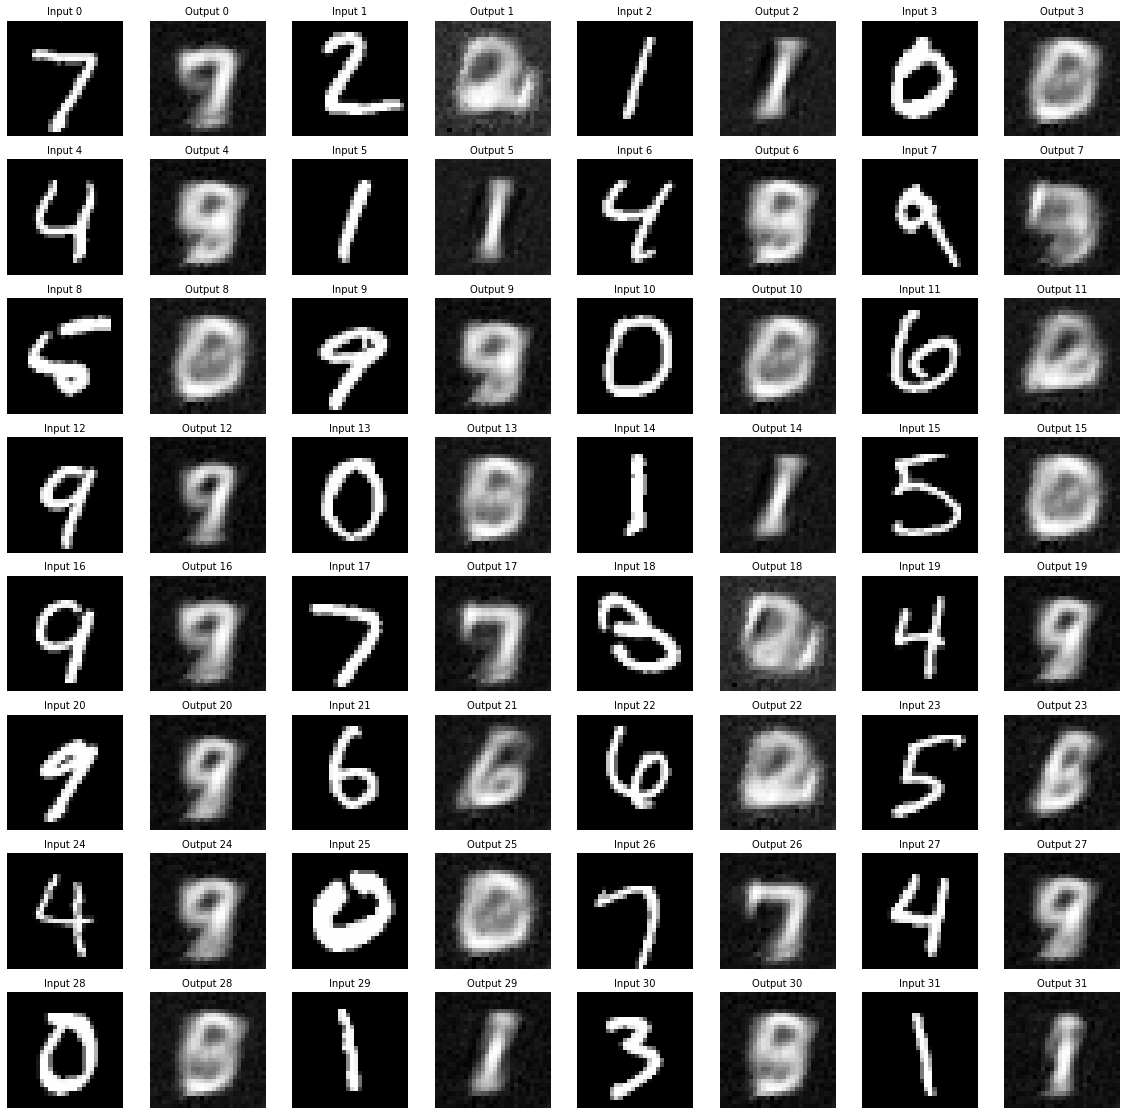

In [14]:
def show_images(x, x_recon):
    """ plots first 32 images and reconstructions"""
    x = x.view(x.shape[0], IMG_H, IMG_W)
    x_recon = x_recon.view(x_recon.shape[0], IMG_H, IMG_W)
    fig, ax = plt.subplots(8, 8, figsize=(20, 20))
    for i in range(8):
        for j in range(4):
            ax[i][2*j].imshow(x[i*4+j].cpu().numpy(), cmap="Greys_r")
            ax[i][2*j+1].imshow(x_recon[i*4+j].cpu().numpy(), cmap="Greys_r")
            ax[i][2*j].set_title(f"Input {i*4+j}", fontsize=10)
            ax[i][2*j+1].set_title(f"Output {i*4+j}", fontsize=10)
            ax[i][2*j].axis('off')
            ax[i][2*j+1].axis('off')
show_images(test_batch, test_batch_recon)